In [1]:
import json
from pathlib import Path

# Load results for a specific problem
problem_id = "problem_6481"  # Your processed problem
results_dir = Path("rollout_results_no_ablation") / problem_id

# Load the sentence rollouts
with open(results_dir / "sentence_rollouts.json", 'r') as f:
    sentence_rollouts_no_ablation = json.load(f)

print(f"Loaded {len(sentence_rollouts_no_ablation)} sentence results")

Loaded 187 sentence results


In [2]:
sentence_rollouts_no_ablation

[{'problem_id': 'problem_6481',
  'sentence_idx': 0,
  'sentence_text': 'Okay, so I have this problem about a square with an area of 81 square units.',
  'function_tags': ['problem_setup'],
  'context_without_sentence': 'Solve this math problem step by step. You MUST put your final answer in \\boxed{}. Problem: Two points are drawn on each side of a square with an area of 81 square units, dividing the side into 3 congruent parts.  Quarter-circle arcs connect the points on adjacent sides to create the figure shown.  What is the length of the boundary of the bolded figure?  Express your answer as a decimal to the nearest tenth. [asy]\nsize(80);\nimport graph;\ndraw((0,0)--(3,0)--(3,3)--(0,3)--cycle, linetype("2 4"));\ndraw(Arc((0,0),1,0,90),linewidth(.8));\ndraw(Arc((0,3),1,0,-90),linewidth(.8));\ndraw(Arc((3,0),1,90,180),linewidth(.8));\ndraw(Arc((3,3),1,180,270),linewidth(.8));\ndraw((1,0)--(2,0),linewidth(.8));draw((3,1)--(3,2),linewidth(.8));\ndraw((1,3)--(2,3),linewidth(.8));draw((0

In [3]:
def check_valid_list(list_rollouts):
  # Check if sentence_idx values are in order
    sentence_indices = [rollout.get('sentence_idx', -1) for rollout in list_rollouts]

    print(f"Found {len(list_rollouts)} rollouts")
    print(f"Sentence indices: {sentence_indices}")
    
    # Check if indices are consecutive starting from 0
    expected_indices = list(range(len(list_rollouts)))
    is_consecutive = sentence_indices == expected_indices
    
    print(f"Expected indices: {expected_indices}")
    print(f"Indices are consecutive from 0: {is_consecutive}")
    
    # Check if indices are sorted (but maybe not starting from 0)
    is_sorted = sentence_indices == sorted(sentence_indices)
    print(f"Indices are sorted: {is_sorted}")
    
    # Find any gaps or duplicates
    unique_indices = set(sentence_indices)
    has_duplicates = len(unique_indices) != len(sentence_indices)
    print(f"Has duplicate indices: {has_duplicates}")

In [4]:
import torch
import math
def calculate_kl_divergence_realmbird(rollout_answer_correct, cos_sims, similarity_threshold=0.8, next_rollout_answer_correct=[]):
    """
    Calculate KL divergence between answer correctness distributions for similar vs dissimilar rollouts.
    This follows the thought-anchors approach.
    
    Args:
        rollout_answer_correct: List of boolean correctness for each rollout
        cos_sims: Tensor of cosine similarities for each rollout
        similarity_threshold: Threshold for determining similar vs dissimilar
        
    Returns:
        dict: Contains KL divergences and group statistics
    """
    # Ensure cos_sims is a tensor
    if not torch.is_tensor(cos_sims):
        cos_sims = torch.tensor(cos_sims, dtype=torch.float32)
    
    
    # Separate rollouts into similar and dissimilar groups
    similar_mask = cos_sims > similarity_threshold
    dissimilar_mask = ~similar_mask
    
    similar_correctness = [rollout_answer_correct[i] for i in range(len(rollout_answer_correct)) if similar_mask[i]]
    dissimilar_correctness = [rollout_answer_correct[i] for i in range(len(rollout_answer_correct)) if dissimilar_mask[i]]
    num_next_correct = sum(next_rollout_answer_correct)

    if len(dissimilar_correctness) == 0 or num_next_correct == 0:
        return {
            "kl_divergence": 0.0,
            "similar_group_size": len(similar_correctness),
            "dissimilar_group_size": len(dissimilar_correctness),
            "similar_accuracy": 0.0,
            "dissimilar_accuracy": 0.0,
            "error": "Insufficient data for KL divergence calculation"
        }
    
    # Calculate accuracy rates for each group
    # similar_accuracy = sum(similar_correctness) / len(similar_correctness)
    eps = 1e-8
    similar_accuracy_and_next = (sum(similar_correctness) + num_next_correct + eps) / (len(similar_correctness) + len(next_rollout_answer_correct) + 2 * eps)
    dissimilar_accuracy = (sum(dissimilar_correctness) + eps) / (len(dissimilar_correctness) + 2 * eps)

    p = dissimilar_accuracy
    q = similar_accuracy_and_next

    kl_div = p * math.log(p / q) + (1 - p) * math.log((1 - p) / (1 - q))
    
    return {
        "kl_divergence": float(kl_div),
        "similar_group_size": len(similar_correctness),
        "dissimilar_group_size": len(dissimilar_correctness),
        "similar_accuracy_and_next": similar_accuracy_and_next,
        "dissimilar_accuracy": dissimilar_accuracy
    }

In [5]:
def process_rollouts_kl_counterfactual_importance(rollouts, sent=True):
  # check_valid_list(rollouts) # can be used to check if the rollouts are in order from 0 - x and no duplicates
  results = []
  for i in range(len(rollouts)-1):
        rollout = rollouts[i]
        #(rollout_answer_correct, cos_sims, similarity_threshold=0.8, next_rollout_answer_correct=[]):
        answer_correct = rollout['rollout_answer_correct']
        cos_sims_sent = rollout['cos_sims_sentence'] #uses sentence model like paper
        cos_sims_llm = rollout['cos_sims_llm'] # uses LLM tokenizer to see sim directly
        next_rollout_answer_correct = rollouts[i+1]['rollout_answer_correct']
        sent_kl_divergence = calculate_kl_divergence_realmbird(answer_correct, cos_sims_sent, similarity_threshold=0.8, next_rollout_answer_correct=next_rollout_answer_correct)
        

        llm_kl_divergence = calculate_kl_divergence_realmbird(answer_correct, cos_sims_llm, similarity_threshold=0.8, next_rollout_answer_correct=next_rollout_answer_correct)

        if sent:
          has_sent_error = "error" in sent_kl_divergence
          if has_sent_error:
            # Set everything to 0 and add error field
            result = {
                "sentence_idx": rollout.get("sentence_idx", i),
                "sentence_category": rollout.get("function_tags", [""])[0],
                "kl_divergence_sent": sent_kl_divergence["kl_divergence"],
                "kl_divergence_llm":  llm_kl_divergence["kl_divergence"],
                "similar_group_size_sent": sent_kl_divergence["similar_group_size"],
                "dissimilar_group_size_sent": sent_kl_divergence["dissimilar_group_size"],
                "similar_group_size_llm": llm_kl_divergence["similar_group_size"],
                "dissimilar_group_size_llm": llm_kl_divergence["dissimilar_group_size"],
                "similar_accuracy_and_next": 0.0,
                "dissimilar_accuracy": 0.0,
                "error": "Insufficient data for KL divergence calculation"
            }
          else:
            # Normal processing
            result = {
                "sentence_idx": rollout.get("sentence_idx", i),
                "sentence_category": rollout.get("function_tags", [""])[0],
                "kl_divergence_sent": sent_kl_divergence["kl_divergence"],
                "kl_divergence_llm": llm_kl_divergence["kl_divergence"],
                "similar_group_size_sent": sent_kl_divergence["similar_group_size"],
                "dissimilar_group_size_sent": sent_kl_divergence["dissimilar_group_size"],
                "similar_group_size_llm": llm_kl_divergence["similar_group_size"],
                "dissimilar_group_size_llm": llm_kl_divergence["dissimilar_group_size"],
                "similar_accuracy_and_next": sent_kl_divergence.get("similar_accuracy_and_next", sent_kl_divergence.get("similar_accuracy", 0.0)),
                "dissimilar_accuracy": sent_kl_divergence["dissimilar_accuracy"]
            }
        else:
          has_llm_error = "error" in llm_kl_divergence
          if has_llm_error:
              # Set everything to 0 and add error field
              result = {
                  "sentence_idx": rollout.get("sentence_idx", i),
                  "sentence_category": rollout.get("function_tags", [""])[0],
                  "kl_divergence_sent": sent_kl_divergence["kl_divergence"],
                  "kl_divergence_llm":  llm_kl_divergence["kl_divergence"],
                  "similar_group_size_sent": sent_kl_divergence["similar_group_size"],
                  "dissimilar_group_size_sent": sent_kl_divergence["dissimilar_group_size"],
                  "similar_group_size_llm": llm_kl_divergence["similar_group_size"],
                  "dissimilar_group_size_llm": llm_kl_divergence["dissimilar_group_size"],
                  "similar_accuracy_and_next": 0.0,
                  "dissimilar_accuracy": 0.0,
                  "error": "Insufficient data for KL divergence calculation"
              }
          else:
              # Normal processing
              result = {
                  "sentence_idx": rollout.get("sentence_idx", i),
                  "sentence_category": rollout.get("function_tags", [""])[0],
                  "kl_divergence_sent": sent_kl_divergence["kl_divergence"],
                  "kl_divergence_llm": llm_kl_divergence["kl_divergence"],
                  "similar_group_size_sent": sent_kl_divergence["similar_group_size"],
                  "dissimilar_group_size_sent": sent_kl_divergence["dissimilar_group_size"],
                  "similar_group_size_llm": llm_kl_divergence["similar_group_size"],
                  "dissimilar_group_size_llm": llm_kl_divergence["dissimilar_group_size"],
                  "similar_accuracy_and_next": sent_kl_divergence.get("similar_accuracy_and_next", sent_kl_divergence.get("similar_accuracy", 0.0)),
                  "dissimilar_accuracy": sent_kl_divergence["dissimilar_accuracy"]
              }
        results.append(result)

        # print(f"Processing rollout for sentence: {rollout['sentence_text']}")
        # Add more processing logic as needed
  return results


In [6]:
kl_results_no_ablation_sent = process_rollouts_kl_counterfactual_importance(sentence_rollouts_no_ablation, sent=True)
kl_results_no_ablation_llm = process_rollouts_kl_counterfactual_importance(sentence_rollouts_no_ablation, sent=False)

In [7]:
def check_errors(kl_results):
    # Check number of errors in kl_results
    error_count = 0
    total_results = len(kl_results)

    for i, result in enumerate(kl_results):
        if "error" in result:
            error_count += 1
            print(f"Error at index {i}: {result['error']}")

    print(f"\nSummary:")
    print(f"Total results: {total_results}")
    print(f"Results with errors: {error_count}")
    print(f"Results without errors: {total_results - error_count}")
    print(f"Error rate: {error_count / total_results * 100:.2f}%")

    # Also check the specific error statistics
    if error_count > 0:
        print(f"\nError details:")
        error_results = [r for r in kl_results if "error" in r]
        print(f"Similar group sizes in errors: {[r['similar_group_size_sent'] for r in error_results]}")
        print(f"Dissimilar group sizes in errors: {[r['dissimilar_group_size_sent'] for r in error_results]}")

In [8]:
import json
from pathlib import Path

# Load ablation results for the same problem
ablation_results_dir = Path("rollout_results_ablation") / problem_id

# Load the sentence rollouts for ablation
with open(ablation_results_dir / "sentence_multi_head_ablation_rollouts.json", 'r') as f:
    sentence_rollouts_ablation = json.load(f)

print(f"Loaded {len(sentence_rollouts_ablation)} ablation sentence results")

Loaded 187 ablation sentence results


In [12]:
kl_divergences_sentences_ablation_result = process_rollouts_kl_counterfactual_importance(sentence_rollouts_ablation, sent=True)
kl_divergences_llm_ablation_result = process_rollouts_kl_counterfactual_importance(sentence_rollouts_ablation, sent=False)

In [10]:
# Extract KL divergence values using list comprehensions
kl_divergences_sentences_no_ablation = [result["kl_divergence_sent"] for result in kl_results_no_ablation_sent]
kl_divergences_llm_no_ablation = [result["kl_divergence_llm"] for result in kl_results_no_ablation_llm]


In [13]:
kl_divergences_llm_ablation = [result["kl_divergence_llm"] for result in kl_divergences_llm_ablation_result]
kl_divergences_sentences_ablation = [result["kl_divergence_sent"] for result in kl_divergences_llm_ablation_result]

In [35]:
# Filter and organize results by sentence category
def filter_by_category(kl_results):
    """
    Filter KL results by sentence category and extract relevant fields.
    
    Args:
        kl_results: List of KL result dictionaries
        category_filter: String to filter by category, or None for all
    
    Returns:
        List of dictionaries with filtered results
    """
    all_categories = set([result.get("sentence_category", "") for result in kl_results])
    filtered_results = {}
    
    for result in kl_results:
        # Apply category filter if specified
        category = result.get("sentence_category", "")
        filtered_result = { 
            "sentence_idx": result["sentence_idx"],
            "sentence_category": result["sentence_category"],
            "kl_divergence_sent": result["kl_divergence_sent"],
            "kl_divergence_llm": result["kl_divergence_llm"],
            "error": result.get("error", None)
        }
        filtered_results[category].append(filtered_result)
    
    return filtered_results


In [ ]:
filter_by_category

In [ ]:
# Extract KL divergence values using list comprehensions
kl_divergences_sentences_no_ablation = [result["kl_divergence_sent"] for result in kl_results_no_ablation_sent]
kl_divergences_llm_no_ablation = [result["kl_divergence_llm"] for result in kl_results_no_ablation_llm]
kl_divergences_llm_ablation = [result["kl_divergence_llm"] for result in kl_divergences_llm_ablation_result]
kl_divergences_sentences_ablation = [result["kl_divergence_sent"] for result in kl_divergences_llm_ablation_result]

NameError: name 'kl_results' is not defined

In [30]:
category_sentences_no_ablation

[]

In [ ]:
# removes errors
kl_divergences_sentences_no_ablation_filtered = [result["kl_divergence_sent"] for result in kl_results_no_ablation_sent if "error" not in result]
kl_divergences_llm_no_ablation_filtered = [result["kl_divergence_llm"] for result in kl_results_no_ablation_llm if "error" not in result]
kl_divergences_sentences_ablation_filtered = [result["kl_divergence_sent"] for result in kl_divergences_sentences_ablation_result if "error" not in result]
kl_divergences_llm_ablation_filtered = [result["kl_divergence_llm"] for result in kl_divergences_llm_ablation_result if "error" not in result]

/tmp/ipykernel_588736/3128030090.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_divergences_sentences_no_ablation,


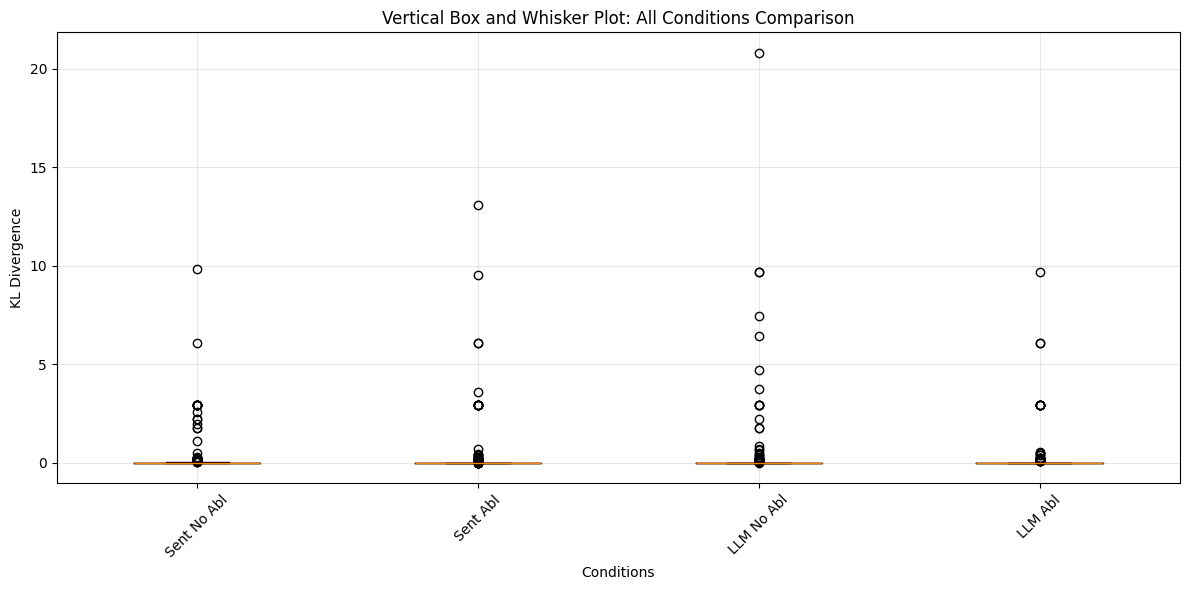

In [15]:
import matplotlib.pyplot as plt

# Create comparative vertical box and whisker plots
plt.figure(figsize=(12, 6))
plt.boxplot([kl_divergences_sentences_no_ablation, 
             kl_divergences_sentences_ablation,
             kl_divergences_llm_no_ablation, 
             kl_divergences_llm_ablation], 
           labels=['Sent No Abl', 'Sent Abl', 'LLM No Abl', 'LLM Abl'], 
           vert=True)
plt.ylabel('KL Divergence')
plt.xlabel('Conditions')
plt.title('Vertical Box and Whisker Plot: All Conditions Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_588736/2403397684.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_divergences_sentences_no_ablation_filtered,


(array([1, 2, 3, 4]),
 [Text(1, 0, 'Sent No Abl'),
  Text(2, 0, 'Sent Abl'),
  Text(3, 0, 'LLM No Abl'),
  Text(4, 0, 'LLM Abl')])

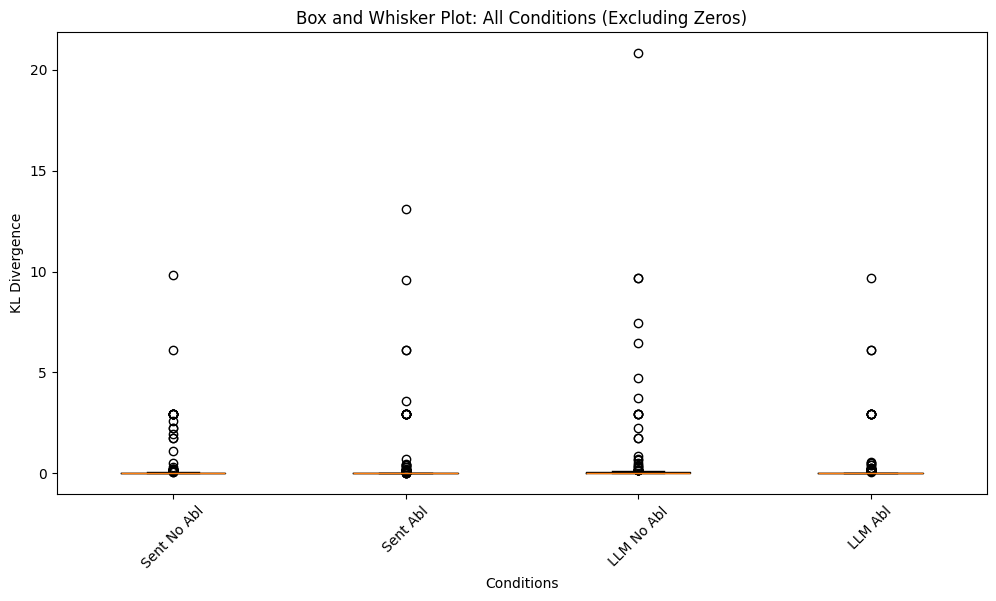

In [16]:
import matplotlib.pyplot as plt

# Create comparative vertical box and whisker plots (excluding zeros)
plt.figure(figsize=(12, 6))
plt.boxplot([kl_divergences_sentences_no_ablation_filtered, 
             kl_divergences_sentences_ablation_filtered,
             kl_divergences_llm_no_ablation_filtered, 
             kl_divergences_llm_ablation_filtered], 
           labels=['Sent No Abl', 'Sent Abl', 'LLM No Abl', 'LLM Abl'], 
           vert=True)
plt.ylabel('KL Divergence')
plt.xlabel('Conditions')
plt.title('Box and Whisker Plot: All Conditions (Excluding Zeros)')
plt.xticks(rotation=45)

In [17]:
import json
from pathlib import Path

# Define the base directory and problem-specific path
base_problem_dir = "math-rollouts/deepseek-r1-distill-llama-8b/temperature_0.6_top_p_0.95/correct_base_solution"
problem_path = Path(base_problem_dir) / "problem_6481" / "chunks_labeled.json"

# Load the JSON file
try:
    with open(problem_path, 'r') as f:
        chunks_labeled = json.load(f)
    
    print(f"Successfully loaded chunks_labeled.json")
    print(f"Data type: {type(chunks_labeled)}")
    
    # Display basic information about the loaded data
    if isinstance(chunks_labeled, list):
        print(f"Number of chunks: {len(chunks_labeled)}")
        if chunks_labeled:
            print(f"First chunk keys: {list(chunks_labeled[0].keys()) if isinstance(chunks_labeled[0], dict) else 'Not a dict'}")
    elif isinstance(chunks_labeled, dict):
        print(f"Top-level keys: {list(chunks_labeled.keys())}")
    
    # Display first few items for inspection
    print(f"\nFirst few items:")
    if isinstance(chunks_labeled, list):
        for i, chunk in enumerate(chunks_labeled[:3]):
            print(f"Chunk {i}: {chunk}")
    else:
        print(chunks_labeled)
        
except FileNotFoundError:
    print(f"File not found: {problem_path}")
    print("Please check the file path and ensure the file exists.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except Exception as e:
    print(f"Error loading file: {e}")

Successfully loaded chunks_labeled.json
Data type: <class 'list'>
Number of chunks: 187
First chunk keys: ['chunk', 'chunk_idx', 'function_tags', 'depends_on', 'accuracy', 'resampling_importance_accuracy', 'resampling_importance_kl', 'counterfactual_importance_accuracy', 'counterfactual_importance_kl', 'forced_importance_accuracy', 'forced_importance_kl', 'different_trajectories_fraction', 'overdeterminedness', 'summary']

First few items:
Chunk 0: {'chunk': 'Okay, so I have this problem about a square with an area of 81 square units.', 'chunk_idx': 0, 'function_tags': ['problem_setup'], 'depends_on': [], 'accuracy': 0.898989898989899, 'resampling_importance_accuracy': -0.09898989898989896, 'resampling_importance_kl': 0.06212096108399145, 'counterfactual_importance_accuracy': 0.042105263157894646, 'counterfactual_importance_kl': 0.08224862729086274, 'forced_importance_accuracy': 0.0, 'forced_importance_kl': 10.757939479731176, 'different_trajectories_fraction': 0.3838383838383838, 'ove

In [18]:
original_kl = [chunk["resampling_importance_kl"] for chunk in chunks_labeled]

In [19]:
original_kl_min = min(original_kl)
original_kl_max = max(original_kl)

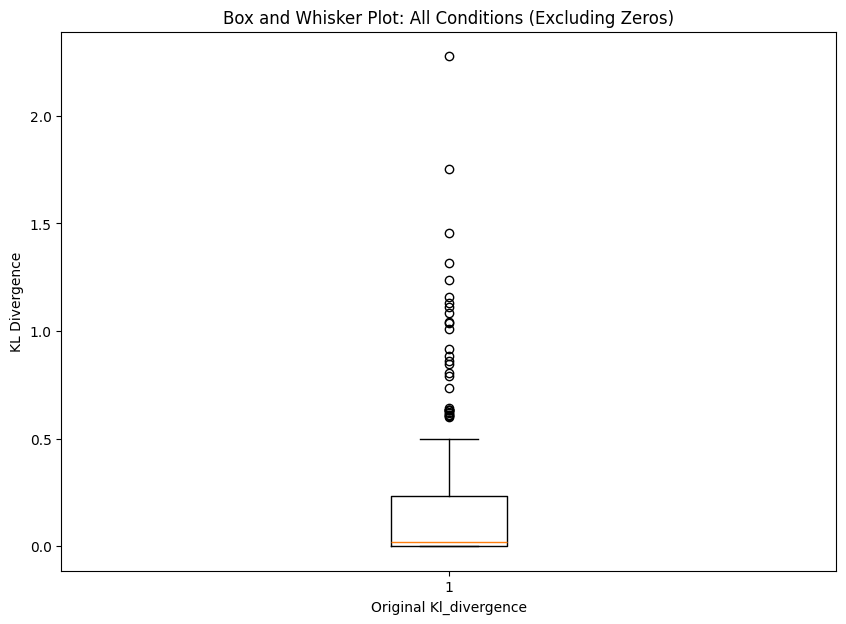

In [20]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(10)

fig = plt.figure(figsize =(10, 7))

plt.boxplot(original_kl)
plt.ylabel('KL Divergence')
plt.xlabel('Original Kl_divergence')
plt.title('Box and Whisker Plot: All Conditions (Excluding Zeros)')
plt.show()

/tmp/ipykernel_588736/617879071.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_divergences_sentences_no_ablation,


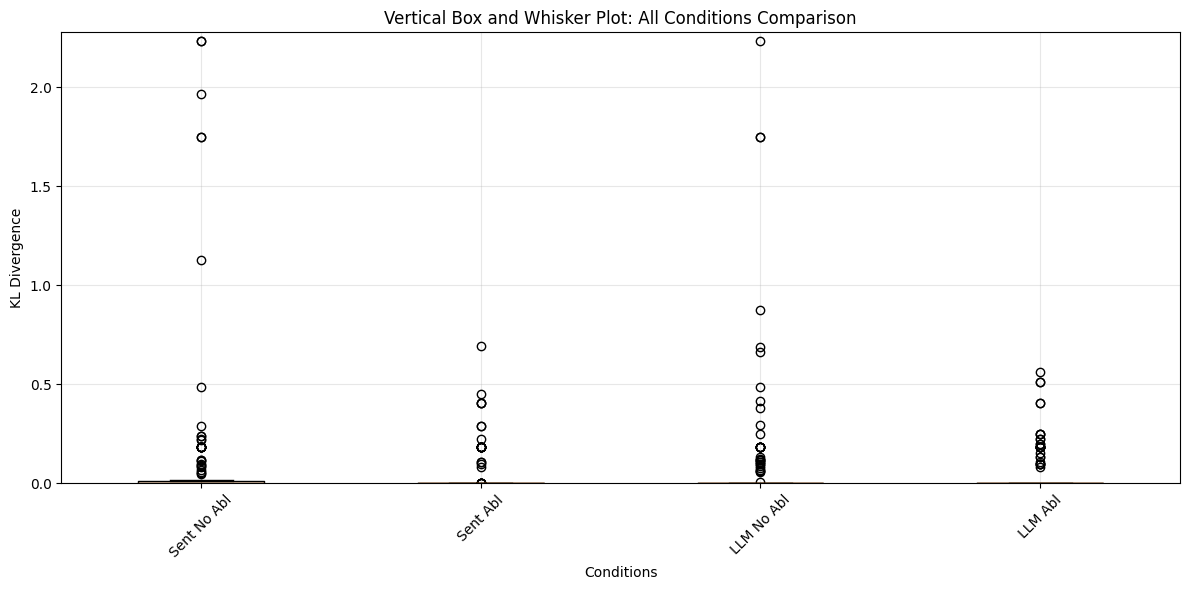

In [21]:
import matplotlib.pyplot as plt

# First, get the range from original_kl
original_kl_min = min(original_kl)
original_kl_max = max(original_kl)

# Create comparative vertical box and whisker plots with same y-range as original
plt.figure(figsize=(12, 6))
plt.boxplot([kl_divergences_sentences_no_ablation, 
             kl_divergences_sentences_ablation,
             kl_divergences_llm_no_ablation, 
             kl_divergences_llm_ablation], 
           labels=['Sent No Abl', 'Sent Abl', 'LLM No Abl', 'LLM Abl'], 
           vert=True)
plt.ylabel('KL Divergence')
plt.xlabel('Conditions')
plt.title('Vertical Box and Whisker Plot: All Conditions Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.ylim(original_kl_min, original_kl_max)  # Set same y-range as original KL
plt.tight_layout()
plt.show()

In [22]:
import numpy as np

# Compute statistics for all conditions
def compute_stats(data, name):
    if len(data) == 0:
        return {"name": name, "mean": 0, "median": 0, "count": 0}
    return {
        "name": name,
        "mean": np.mean(data),
        "median": np.median(data),
        "count": len(data)
    }

# Compute statistics for all conditions
stats_sent_no_abl = compute_stats(kl_divergences_sentences_no_ablation, "Sentence No Ablation")
stats_sent_abl = compute_stats(kl_divergences_sentences_ablation, "Sentence Ablation")
stats_llm_no_abl = compute_stats(kl_divergences_llm_no_ablation, "LLM No Ablation")
stats_llm_abl = compute_stats(kl_divergences_llm_ablation, "LLM Ablation")

# Also compute for filtered (non-zero) data
stats_sent_no_abl_filt = compute_stats(kl_divergences_sentences_no_ablation_filtered, "Sentence No Ablation (Filtered)")
stats_sent_abl_filt = compute_stats(kl_divergences_sentences_ablation_filtered, "Sentence Ablation (Filtered)")
stats_llm_no_abl_filt = compute_stats(kl_divergences_llm_no_ablation_filtered, "LLM No Ablation (Filtered)")
stats_llm_abl_filt = compute_stats(kl_divergences_llm_ablation_filtered, "LLM Ablation (Filtered)")

# Print results
print("=== STATISTICS COMPARISON ===\n")

print("ALL DATA (including zeros):")
for stats in [stats_sent_no_abl, stats_sent_abl, stats_llm_no_abl, stats_llm_abl]:
    print(f"{stats['name']:25} | Mean: {stats['mean']:.4f} | Median: {stats['median']:.4f} | Count: {stats['count']}")

print("\nFILTERED DATA (excluding zeros):")
for stats in [stats_sent_no_abl_filt, stats_sent_abl_filt, stats_llm_no_abl_filt, stats_llm_abl_filt]:
    print(f"{stats['name']:30} | Mean: {stats['mean']:.4f} | Median: {stats['median']:.4f} | Count: {stats['count']}")

print("\n=== COMPARISONS ===")

print("\nSENTENCE EMBEDDINGS:")
print(f"No Ablation vs Ablation (Mean): {stats_sent_no_abl['mean']:.4f} vs {stats_sent_abl['mean']:.4f} | Diff: {stats_sent_no_abl['mean'] - stats_sent_abl['mean']:.4f}")
print(f"No Ablation vs Ablation (Median): {stats_sent_no_abl['median']:.4f} vs {stats_sent_abl['median']:.4f} | Diff: {stats_sent_no_abl['median'] - stats_sent_abl['median']:.4f}")

print("\nLLM EMBEDDINGS:")
print(f"No Ablation vs Ablation (Mean): {stats_llm_no_abl['mean']:.4f} vs {stats_llm_abl['mean']:.4f} | Diff: {stats_llm_no_abl['mean'] - stats_llm_abl['mean']:.4f}")
print(f"No Ablation vs Ablation (Median): {stats_llm_no_abl['median']:.4f} vs {stats_llm_abl['median']:.4f} | Diff: {stats_llm_no_abl['median'] - stats_llm_abl['median']:.4f}")

print("\nFILTERED COMPARISONS:")
print("\nSENTENCE EMBEDDINGS (Filtered):")
print(f"No Ablation vs Ablation (Mean): {stats_sent_no_abl_filt['mean']:.4f} vs {stats_sent_abl_filt['mean']:.4f} | Diff: {stats_sent_no_abl_filt['mean'] - stats_sent_abl_filt['mean']:.4f}")
print(f"No Ablation vs Ablation (Median): {stats_sent_no_abl_filt['median']:.4f} vs {stats_sent_abl_filt['median']:.4f} | Diff: {stats_sent_no_abl_filt['median'] - stats_sent_abl_filt['median']:.4f}")

print("\nLLM EMBEDDINGS (Filtered):")
print(f"No Ablation vs Ablation (Mean): {stats_llm_no_abl_filt['mean']:.4f} vs {stats_llm_abl_filt['mean']:.4f} | Diff: {stats_llm_no_abl_filt['mean'] - stats_llm_abl_filt['mean']:.4f}")
print(f"No Ablation vs Ablation (Median): {stats_llm_no_abl_filt['median']:.4f} vs {stats_llm_abl_filt['median']:.4f} | Diff: {stats_llm_no_abl_filt['median'] - stats_llm_abl_filt['median']:.4f}")

=== STATISTICS COMPARISON ===

ALL DATA (including zeros):
Sentence No Ablation      | Mean: 0.3244 | Median: 0.0000 | Count: 186
Sentence Ablation         | Mean: 0.3777 | Median: 0.0000 | Count: 186
LLM No Ablation           | Mean: 0.4671 | Median: 0.0000 | Count: 186
LLM Ablation              | Mean: 0.2620 | Median: 0.0000 | Count: 186

FILTERED DATA (excluding zeros):
Sentence No Ablation (Filtered) | Mean: 0.3371 | Median: 0.0000 | Count: 179
Sentence Ablation (Filtered)   | Mean: 0.3969 | Median: 0.0000 | Count: 177
LLM No Ablation (Filtered)     | Mean: 0.5081 | Median: 0.0000 | Count: 171
LLM Ablation (Filtered)        | Mean: 0.2850 | Median: 0.0000 | Count: 171

=== COMPARISONS ===

SENTENCE EMBEDDINGS:
No Ablation vs Ablation (Mean): 0.3244 vs 0.3777 | Diff: -0.0533
No Ablation vs Ablation (Median): 0.0000 vs 0.0000 | Diff: 0.0000

LLM EMBEDDINGS:
No Ablation vs Ablation (Mean): 0.4671 vs 0.2620 | Diff: 0.2051
No Ablation vs Ablation (Median): 0.0000 vs 0.0000 | Diff: 0.00

/tmp/ipykernel_588736/2074236464.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_divergences_sentences_no_ablation_filtered,


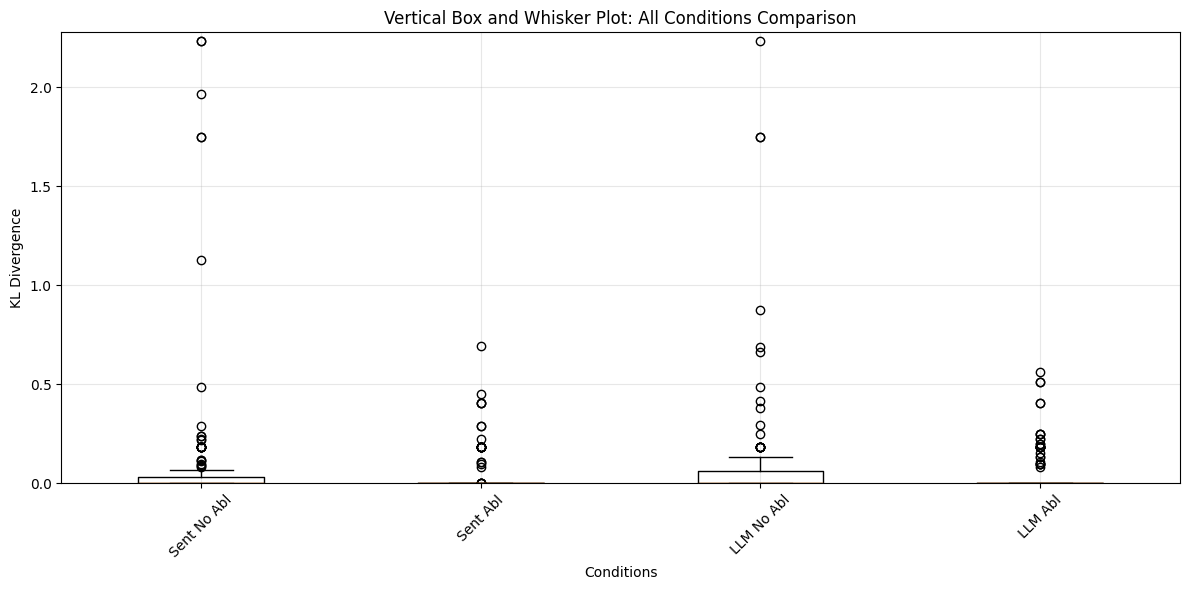

In [23]:
import matplotlib.pyplot as plt

# First, get the range from original_kl
original_kl_min = min(original_kl)
original_kl_max = max(original_kl)

# Create comparative vertical box and whisker plots with same y-range as original
plt.figure(figsize=(12, 6))
plt.boxplot([kl_divergences_sentences_no_ablation_filtered, 
             kl_divergences_sentences_ablation_filtered,
             kl_divergences_llm_no_ablation_filtered, 
             kl_divergences_llm_ablation_filtered], 
           labels=['Sent No Abl', 'Sent Abl', 'LLM No Abl', 'LLM Abl'], 
           vert=True)
plt.ylabel('KL Divergence')
plt.xlabel('Conditions')
plt.title('Vertical Box and Whisker Plot: All Conditions Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.ylim(original_kl_min, original_kl_max)  # Set same y-range as original KL
plt.tight_layout()
plt.show()

In [24]:
#important functions in thought anchors
# def process_chunk_importance
# def calculate_counterfactual_importance_accuracy(chunk_idx, chunk_info, chunk_embedding_cache, chunk_accuracies, args):
    
# def calculate_kl_divergence(chunk_sols1, chunk_sols2, laplace_smooth=False, use_prob_true=True):
# def calculate_counterfactual_importance_kl(chunk_idx, chunk_info, chunk_embedding_cache, chunk_accuracies, chunk_answers, args):